# Goal
* Model data using an MLP
* Use the torch optimizer Adam instead of our simple optimizer we used in past videos. 
* Model a more complex function
$$y = \frac {x^2}{(x+0.2)(x-0.9)sin(2\pi x)}$$

In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [177]:
%matplotlib inline

In [178]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)
    
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

def make_mlp(n = 20, layers_count = 3, act = Mish):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        loss = F.mse_loss(yb,yprime )
        loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [179]:
do_step = Stepper()

In [180]:
x = torch.linspace(-1,1, 200)

In [181]:
from math import pi

In [182]:
def num(x): return x**2
def denom(x): return (x+0.2)*(x-0.9)*torch.sin(pi*2*x)
def my_fun(x): return torch.clamp(torch.tensor(np.nan_to_num( num(x)/denom(x))), -1e2, 1e2)

In [183]:
ytest = my_fun(x)

In [184]:
# ytest

In [185]:
def add_grid_and_ylim():
    plt.grid()
    r = 30
    plt.ylim([-r,r])

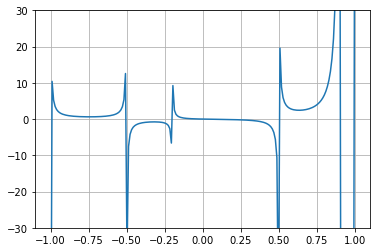

In [186]:
plt.plot(x,ytest)
add_grid_and_ylim()

In [187]:
y = my_fun(x)

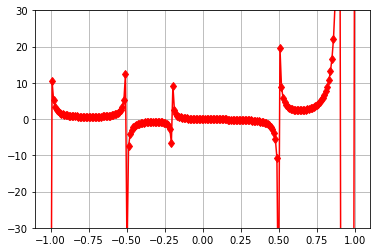

In [188]:
plt.plot(x,y, "rd-")
add_grid_and_ylim()

In [189]:
mlp = make_mlp(act = Mish)

xb, yb = [make_batch(z) for z in [x,y]]

# xb

yprime = mlp(xb)
# yprime

# yprime_debatch = debatch(yprime)

# plt.plot(x,y, "rd-", label = "true")
# plt.plot(x,yprime_debatch, "gs-", label = "MLP")
# add_grid_and_ylim()

In [190]:
for i in range(3000):
    yprime_out_grad_descent = do_step(mlp, xb, yb, lr = 1e-3)

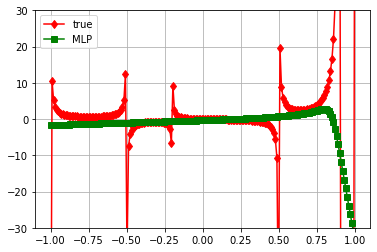

In [191]:
plt.plot(x,y, "rd-", label = "true")
plt.plot(x,yprime_out_grad_descent, "gs-", label = "MLP")
plt.legend()
add_grid_and_ylim()

# Trying to use Adam

In [192]:
from torch.optim import Adam
from fastcore.basics import *

In [193]:
class Stepper_v2:
    """Use the adam optimizer"""
    def __init__(self, mlp, xb, yb, lr = 0.001):
        store_attr("mlp, xb, yb, lr")
        
    def do_epochs(self, epochs, lr = None):
        lr = self.lr if lr is None else lr
        self.optimizer = Adam(self.mlp.parameters(), lr = lr)
        self.loss_list = []
        for i in range(epochs):
            self.optimizer.zero_grad()
            self.yprime = self.mlp(self.xb)
            self.loss = F.mse_loss(self.yb, self.yprime)
            self.loss.backward()
            self.optimizer.step()
            self.loss_list.append(self.loss.detach())

In [194]:
mlp = make_mlp(act = Mish)
xb, yb = [make_batch(z) for z in [x,y]]
stepper = Stepper_v2(mlp, xb, yb, lr = 1e-3 )

In [195]:
stepper.do_epochs(3000)

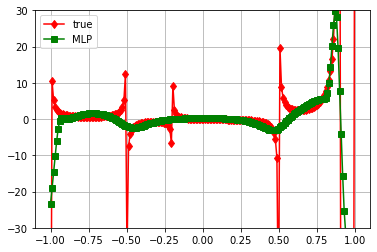

In [196]:
yprime_out_adam = debatch(stepper.yprime)

plt.plot(x,y, "rd-", label = "true")
plt.plot(x,yprime_out_adam, "gs-", label = "MLP")
plt.legend()
add_grid_and_ylim()

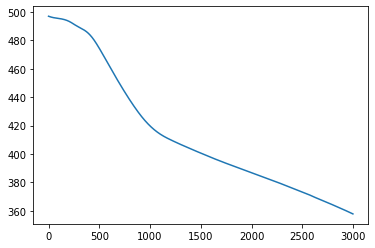

In [197]:
plt.plot(stepper.loss_list)

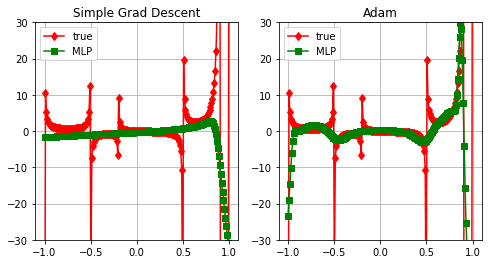

In [199]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))

for i, (y_value, title) in enumerate(zip([yprime_out_grad_descent,yprime_out_adam ], ['Simple Grad Descent', 'Adam'])):

    ax[i].plot(x,y, "rd-", label = "true")
    ax[i].plot(x,y_value, "gs-", label = "MLP")
    ax[i].legend()
#     add_grid_and_ylim()
    ax[i].grid()
    r = 30
    ax[i].set_ylim([-r,r])
    ax[i].set_title(title)